In [1]:
import os, random, keras, h5py, gc
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import keras.models as Model
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Reshape, Conv1D, Flatten, Dense, MaxPooling2D
from keras.models import load_model, Sequential

In [2]:
f = h5py.File('ExtractDataset/part0.h5')
sample_num = f['X'].shape[0]
idx = np.random.choice(range(sample_num), size=sample_num)
X = f['X'][:][idx]
Y = f['Y'][:][idx]
Z = f['Z'][:][idx]
f.close()

for i in range(1,24):
    filename = 'ExtractDataset/part'+str(i) + '.h5'
    f = h5py.File(filename,'r')
    X = np.vstack((X,f['X'][:][idx]))
    Y = np.vstack((Y,f['Y'][:][idx]))
    Z = np.vstack((Z,f['Z'][:][idx]))
    gc.collect()
    f.close()


print('X-size：',X.shape)
print('Y-size：',Y.shape)
print('Z-size：',Z.shape)

X-size： (748800, 1024, 2)
Y-size： (748800, 24)
Z-size： (748800, 1)


In [3]:
n_examples = X.shape[0]
n_train = int(n_examples * 0.9)
train_idx = np.random.choice(range(0,n_examples), size=n_train, replace=False)  
test_idx = list(set(range(0,n_examples))-set(train_idx))
X_train = X[train_idx]  
X_test =  X[test_idx]  
Y_train = Y[train_idx]
Y_test = Y[test_idx]
Z_train = Z[train_idx]
Z_test = Z[test_idx]
print("X_train:",X_train.shape)
print("Y_train:",Y_train.shape)
print("X_test:",X_test.shape)
print("Y_test:",Y_test.shape)

X_train: (673920, 1024, 2)
Y_train: (673920, 24)
X_test: (74880, 1024, 2)
Y_test: (74880, 24)


In [4]:
classes = ['32PSK',
 '16APSK',
 '32QAM',
 'FM',
 'GMSK',
 '32APSK',
 'OQPSK',
 '8ASK',
 'BPSK',
 '8PSK',
 'AM-SSB-SC',
 '4ASK',
 '16PSK',
 '64APSK',
 '128QAM',
 '128APSK',
 'AM-DSB-SC',
 'AM-SSB-WC',
 '64QAM',
 'QPSK',
 '256QAM',
 'AM-DSB-WC',
 'OOK',
 '16QAM']


def baseline_cnn_model(X_train,classes):
    in_shp = X_train.shape[1:]
    
    cnn_model_input = Input(in_shp)
    cnn_model = Sequential()(cnn_model_input)
    cnn_model = Reshape([1,1024,2], input_shape=in_shp)(cnn_model)
    cnn_model = Conv1D(64, kernel_size=3, padding='same', activation='relu')(cnn_model)
    cnn_model = MaxPooling2D(pool_size=2, strides=2, data_format="channels_first")(cnn_model)
    cnn_model = Conv1D(64, kernel_size=3, padding='same', activation='relu')(cnn_model)
    cnn_model = MaxPooling2D(pool_size=2, strides=2, data_format="channels_first")(cnn_model)
    cnn_model = Conv1D(64, kernel_size=3, padding='same', activation='relu')(cnn_model)
    cnn_model = MaxPooling2D(pool_size=2, strides=2, data_format="channels_first")(cnn_model)
    cnn_model = Conv1D(64, kernel_size=3, padding='same', activation='relu')(cnn_model)
    cnn_model = MaxPooling2D(pool_size=2, strides=2, data_format="channels_first")(cnn_model)
    cnn_model = Conv1D(64, kernel_size=3, padding='same', activation='relu')(cnn_model)
    cnn_model = MaxPooling2D(pool_size=2, strides=2, data_format="channels_first")(cnn_model)
    cnn_model = Conv1D(64, kernel_size=3, padding='same', activation='relu')(cnn_model)
    cnn_model = MaxPooling2D(pool_size=2, strides=2, data_format="channels_first")(cnn_model)
    cnn_model = Conv1D(64, kernel_size=3, padding='same', activation='relu')(cnn_model)
    cnn_model = MaxPooling2D(pool_size=2, strides=2, data_format="channels_first")(cnn_model)
    cnn_model = Flatten()(cnn_model)
    cnn_model = Dense(128, activation='selu')(cnn_model)
    cnn_model = Dense(128, activation='selu')(cnn_model)
    cnn_model = Dense(len(classes), activation='softmax')(cnn_model)
    
    return tf.keras.models.Model(inputs=cnn_model_input, outputs=cnn_model) 
    
model = baseline_cnn_model(X_train,classes) 

model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1024, 2)]         0         
                                                                 
 sequential (Sequential)     multiple                  0         
                                                                 
 reshape (Reshape)           (None, 1, 1024, 2)        0         
                                                                 
 conv1d (Conv1D)             (None, 1, 1024, 64)       448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 1, 512, 32)       0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 1, 512, 64)        6208      
                                                             

In [5]:
gc.collect()
filepath = 'cnn_model.keras'
history = model.fit(X_train,
    Y_train,
    batch_size=1024,
    epochs=100,
    verbose=1,
    validation_split = 0.1,
    callbacks = [
        tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto'),
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')
    ])

Epoch 1/100
593/593 [==============================] - ETA: 0s - loss: 2.1742 - accuracy: 0.2524
Epoch 1: val_loss improved from inf to 1.88864, saving model to cnn_model.keras
593/593 [==============================] - 439s 468ms/step - loss: 2.1742 - accuracy: 0.2524 - val_loss: 1.8886 - val_accuracy: 0.3214
Epoch 2/100
593/593 [==============================] - ETA: 0s - loss: 1.8197 - accuracy: 0.3472
Epoch 2: val_loss improved from 1.88864 to 1.77940, saving model to cnn_model.keras
593/593 [==============================] - 40s 68ms/step - loss: 1.8197 - accuracy: 0.3472 - val_loss: 1.7794 - val_accuracy: 0.3592
Epoch 3/100
591/593 [============================>.] - ETA: 0s - loss: 1.7581 - accuracy: 0.3707
Epoch 3: val_loss improved from 1.77940 to 1.73130, saving model to cnn_model.keras
593/593 [==============================] - 20s 34ms/step - loss: 1.7581 - accuracy: 0.3707 - val_loss: 1.7313 - val_accuracy: 0.3795
Epoch 4/100
591/593 [============================>.] - ETA: 

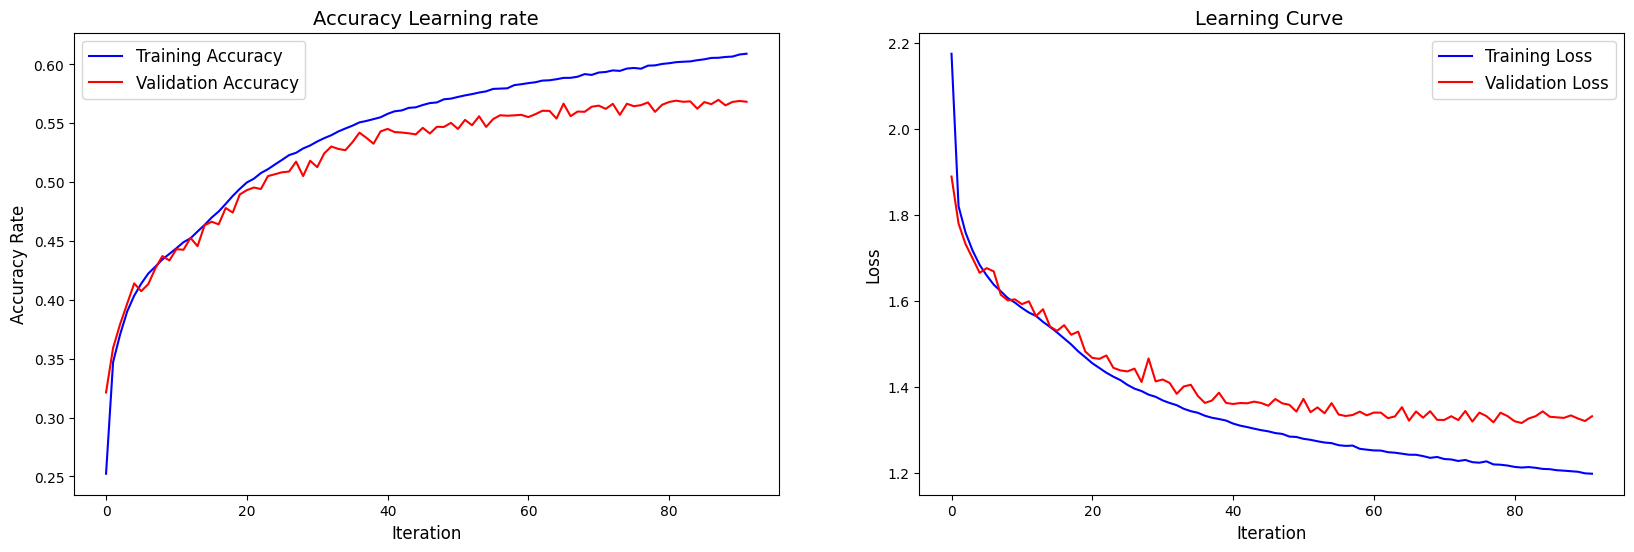

In [6]:
fig, ((ax1, ax2)) = plt.subplots(nrows=1, ncols=2,figsize=(20,6))

ax1.plot(history.history['accuracy'],'b', history.history['val_accuracy'], 'r')
ax1.set_ylabel('Accuracy Rate',fontsize=12)
ax1.set_xlabel('Iteration',fontsize=12)
ax1.set_title('Accuracy Learning rate',fontsize=14)
ax1.legend(['Training Accuracy','Validation Accuracy'],fontsize=12,loc='best')

ax2.plot(history.history['loss'], 'b',history.history['val_loss'],'r')
ax2.set_ylabel('Loss',fontsize=12)
ax2.set_xlabel('Iteration',fontsize=12)
ax2.set_title('Learning Curve ',fontsize=14)
ax2.legend(['Training Loss','Validation Loss'],fontsize=12,loc='best')

plt.show()

74/74 [==============================] - 1s 12ms/step


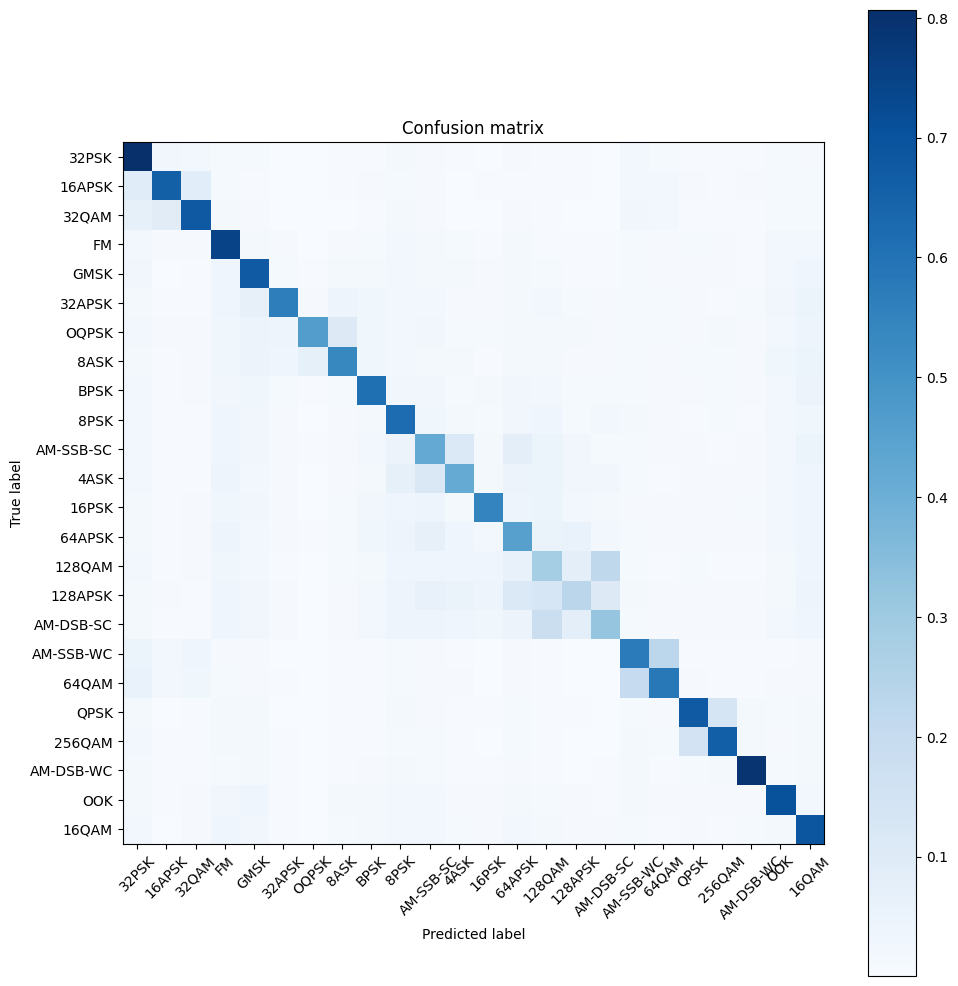

In [7]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
batch_size = 1024
test_Y_hat = model.predict(X_test, batch_size)
conf = np.zeros([len(classes),len(classes)])
confnorm = np.zeros([len(classes),len(classes)])
for i in range(0,X_test.shape[0]):
    j = list(Y_test[i,:]).index(1)
    k = int(np.argmax(test_Y_hat[i,:]))
    conf[j,k] = conf[j,k] + 1
for i in range(0,len(classes)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
plot_confusion_matrix(confnorm, labels=classes)

In [8]:
for i in range(len(confnorm)):
    print(classes[i],confnorm[i,i])

32PSK 0.8067678684376977
16APSK 0.6562397102403688
32QAM 0.6792571608435631
FM 0.7454316320100819
GMSK 0.6771139405811296
32APSK 0.5641958967571145
OQPSK 0.46189881324172394
8ASK 0.5338683788121991
BPSK 0.6088631984585742
8PSK 0.6201320132013202
AM-SSB-SC 0.42095238095238097
4ASK 0.41653054557334207
16PSK 0.5431404958677686
64APSK 0.45388731507711677
128QAM 0.2853133769878391
128APSK 0.22796164553046705
AM-DSB-SC 0.32090032154340836
AM-SSB-WC 0.5709208400646204
64QAM 0.5815647766867279
QPSK 0.674565560821485
256QAM 0.6596228868660599
AM-DSB-WC 0.7922690131992458
OOK 0.7018012008005337
16QAM 0.6883735705209657


92/92 [==============================] - 0s 2ms/step
Overall Accuracy -20:  0.07223168654173764
87/87 [==============================] - 0s 2ms/step
Overall Accuracy -18:  0.0693994965839626
86/86 [==============================] - 0s 2ms/step
Overall Accuracy -16:  0.07560262965668371
92/92 [==============================] - 0s 2ms/step
Overall Accuracy -14:  0.08565601631543168
90/90 [==============================] - 0s 2ms/step
Overall Accuracy -12:  0.10286913925822254
87/87 [==============================] - 0s 2ms/step
Overall Accuracy -10:  0.13929088277858176
96/96 [==============================] - 0s 2ms/step
Overall Accuracy -8:  0.19540229885057472
90/90 [==============================] - 0s 2ms/step
Overall Accuracy -6:  0.27087719298245616
91/91 [==============================] - 0s 2ms/step
Overall Accuracy -4:  0.34970800412229475
89/89 [==============================] - 0s 2ms/step
Overall Accuracy -2:  0.4212376933895921
94/94 [==============================] - 0s 2m

C:\Users\SomeUnknown\AppData\Local\Temp\ipykernel_5300\925050271.py:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


90/90 [==============================] - 0s 2ms/step
Overall Accuracy 2:  0.6296296296296297
93/93 [==============================] - 0s 2ms/step
Overall Accuracy 4:  0.6986531986531986
94/94 [==============================] - 0s 3ms/step
Overall Accuracy 6:  0.7886666666666666
88/88 [==============================] - 0s 2ms/step
Overall Accuracy 8:  0.8300606926097822
95/95 [==============================] - 0s 2ms/step
Overall Accuracy 10:  0.8465871438038436
91/91 [==============================] - 0s 2ms/step
Overall Accuracy 12:  0.8636049723756906
89/89 [==============================] - 0s 2ms/step
Overall Accuracy 14:  0.868346344925479
89/89 [==============================] - 0s 2ms/step
Overall Accuracy 16:  0.8648744251857092
90/90 [==============================] - 0s 2ms/step
Overall Accuracy 18:  0.8717589348283111
91/91 [==============================] - 0s 2ms/step
Overall Accuracy 20:  0.8724066390041494
94/94 [==============================] - 0s 2ms/step
Overall Accu

<Figure size 640x480 with 0 Axes>

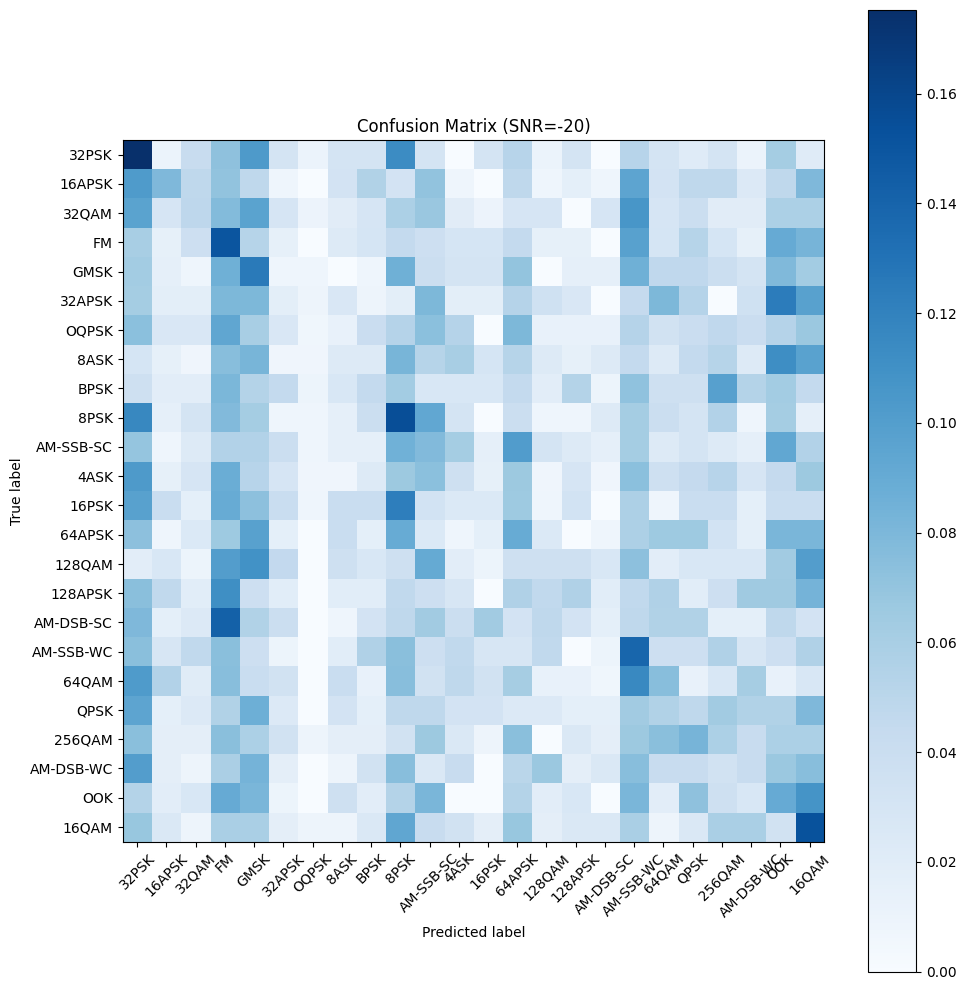

<Figure size 640x480 with 0 Axes>

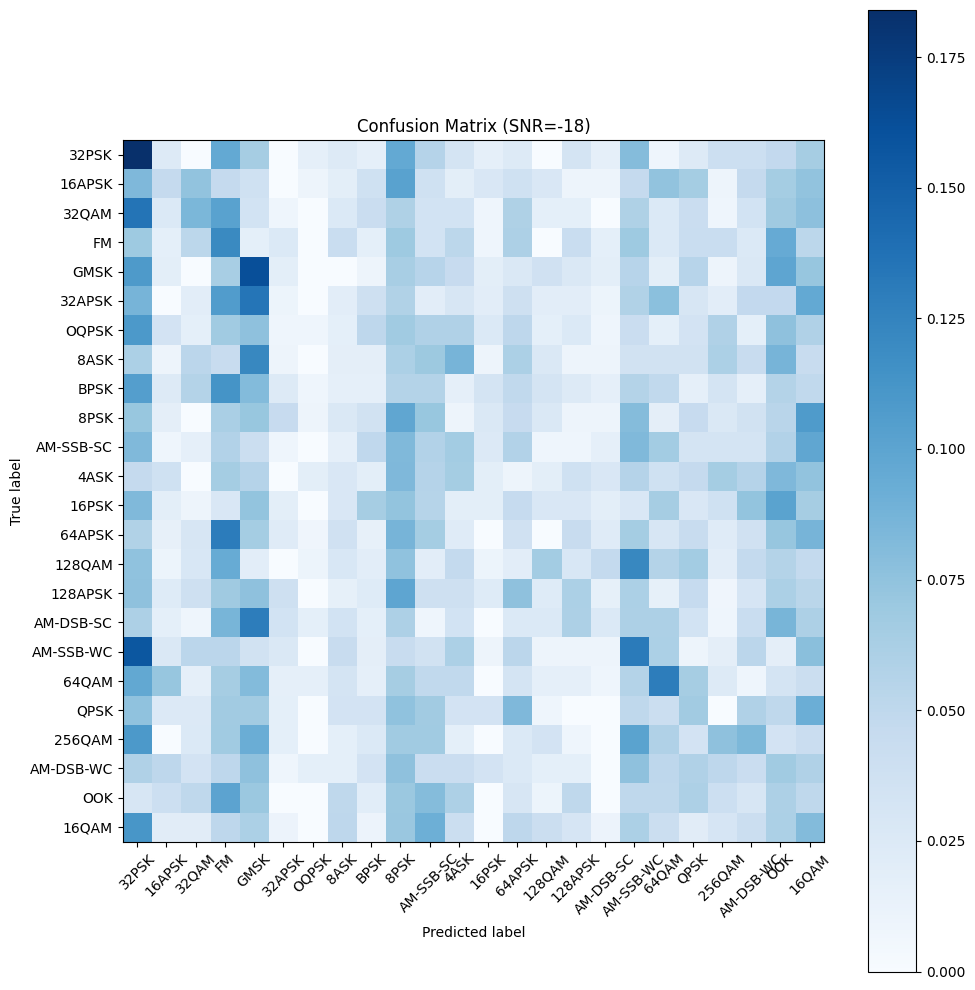

<Figure size 640x480 with 0 Axes>

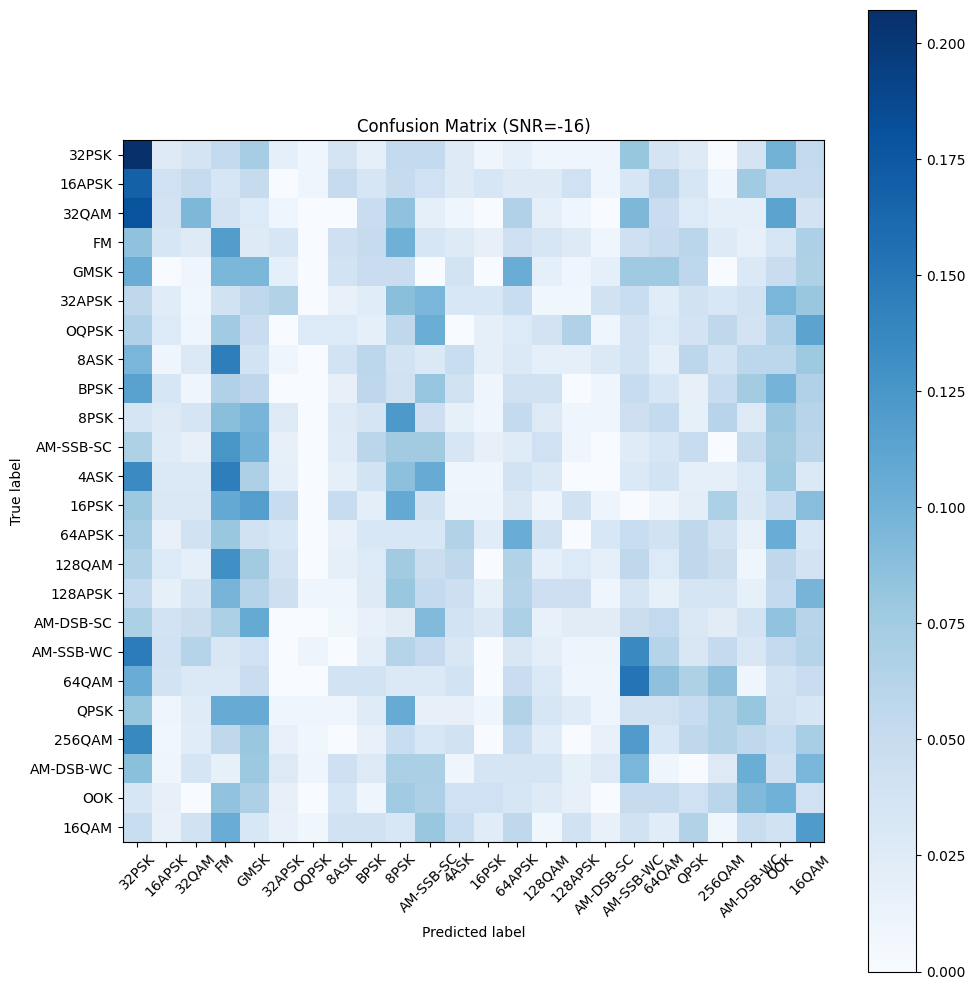

<Figure size 640x480 with 0 Axes>

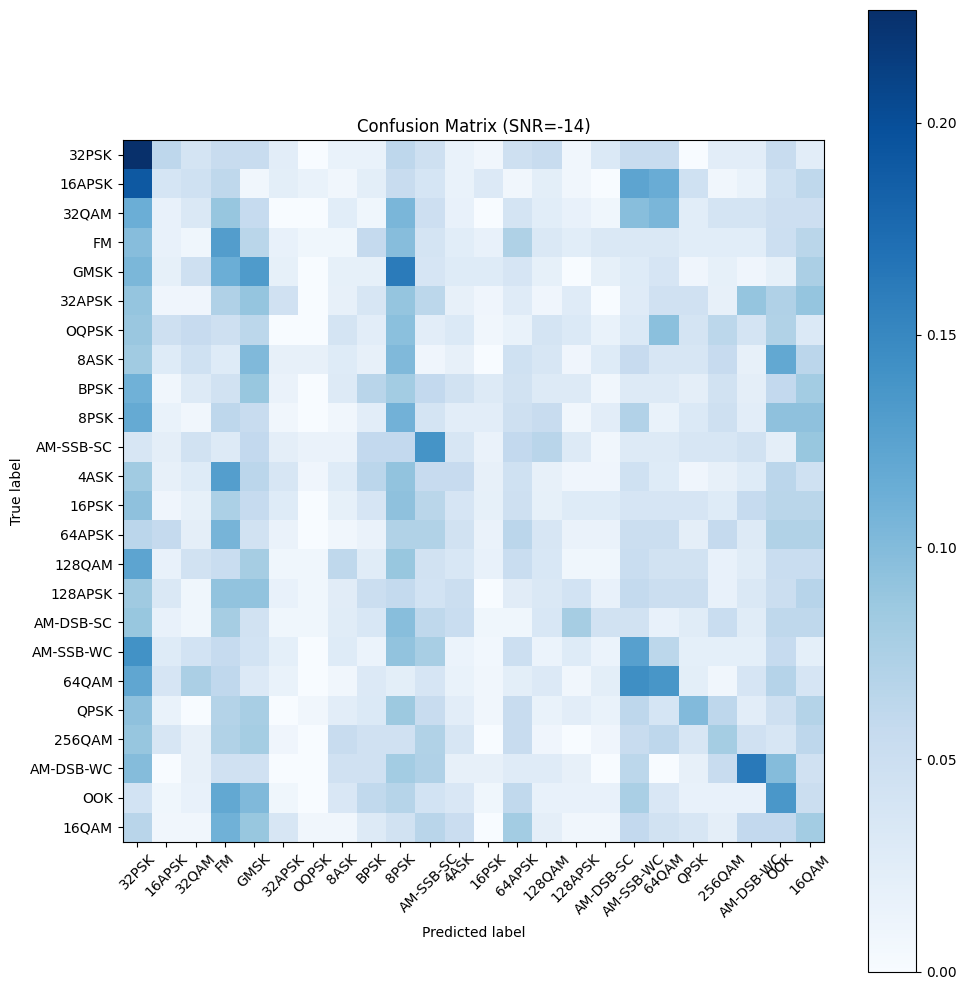

<Figure size 640x480 with 0 Axes>

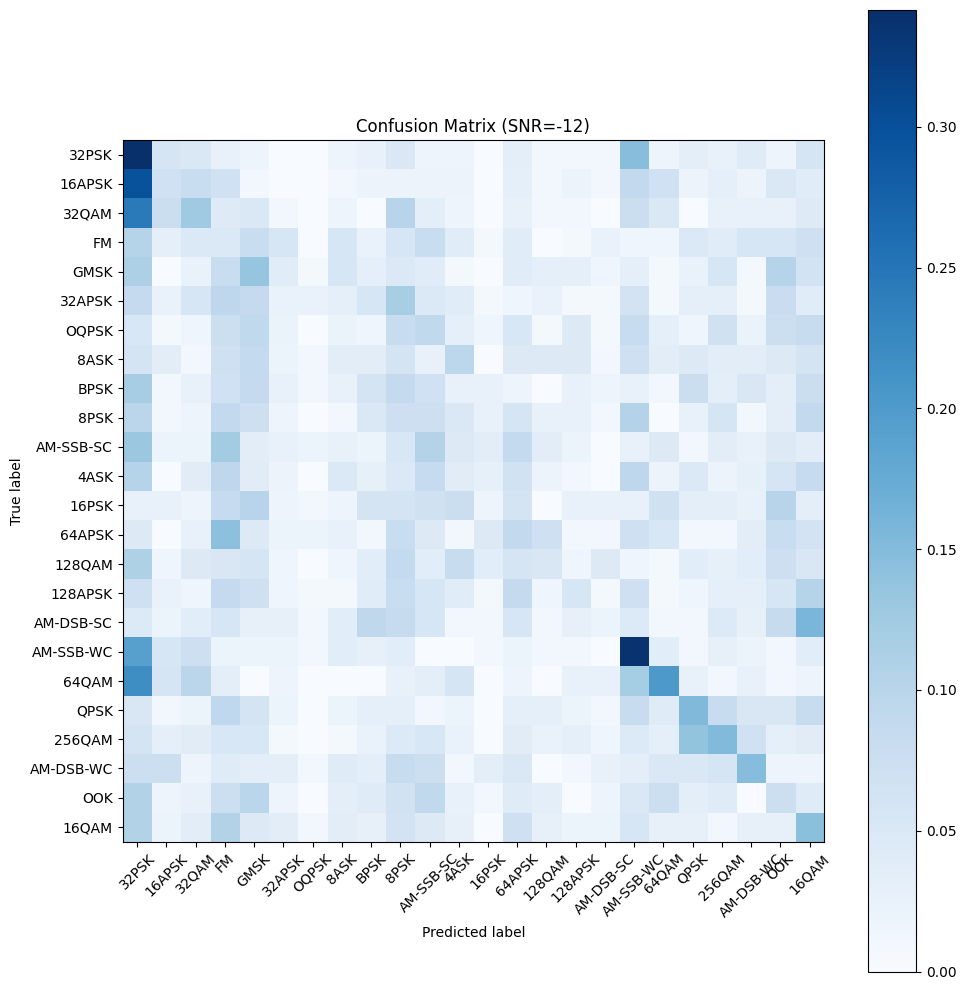

<Figure size 640x480 with 0 Axes>

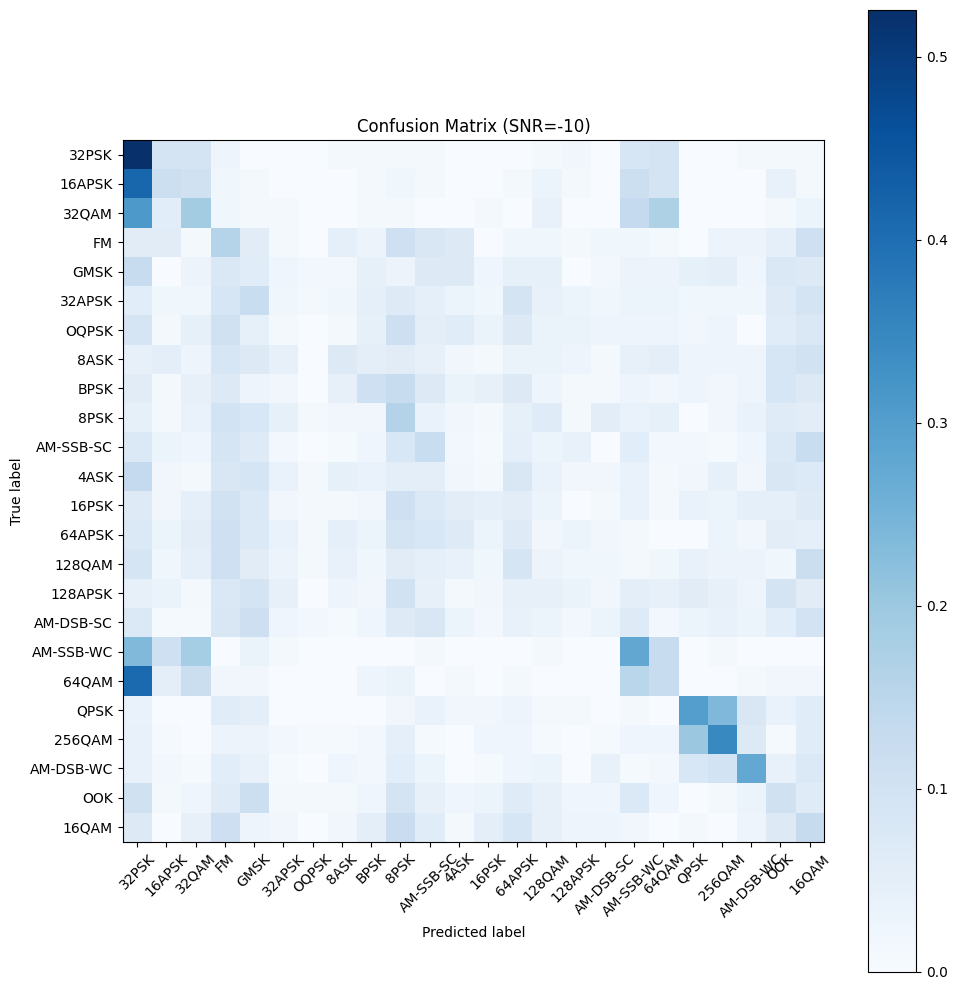

<Figure size 640x480 with 0 Axes>

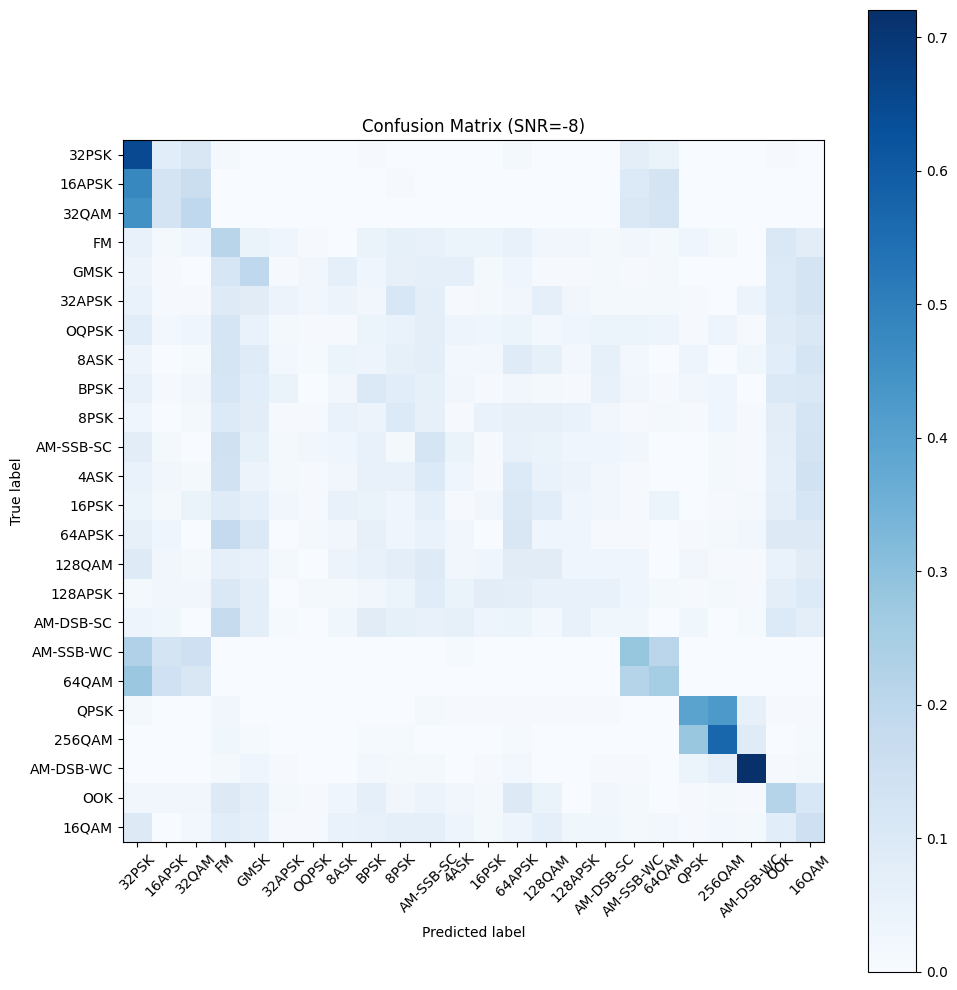

<Figure size 640x480 with 0 Axes>

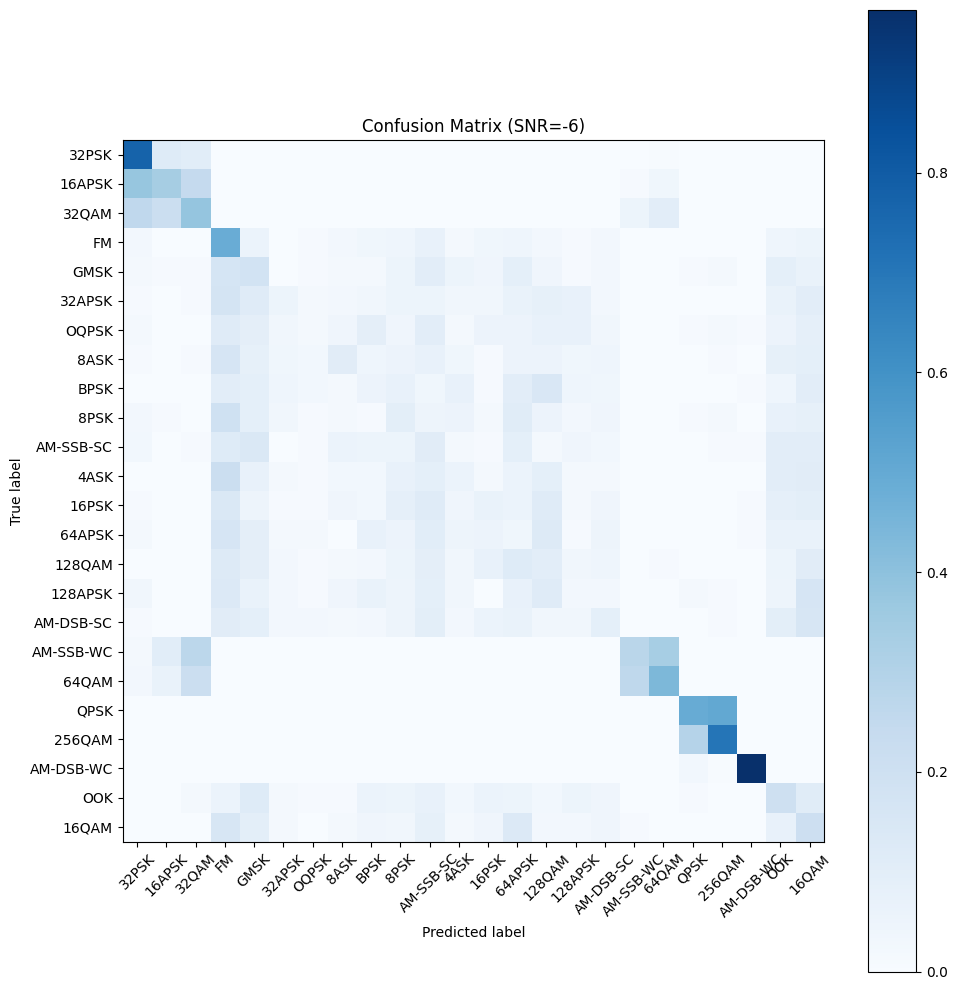

<Figure size 640x480 with 0 Axes>

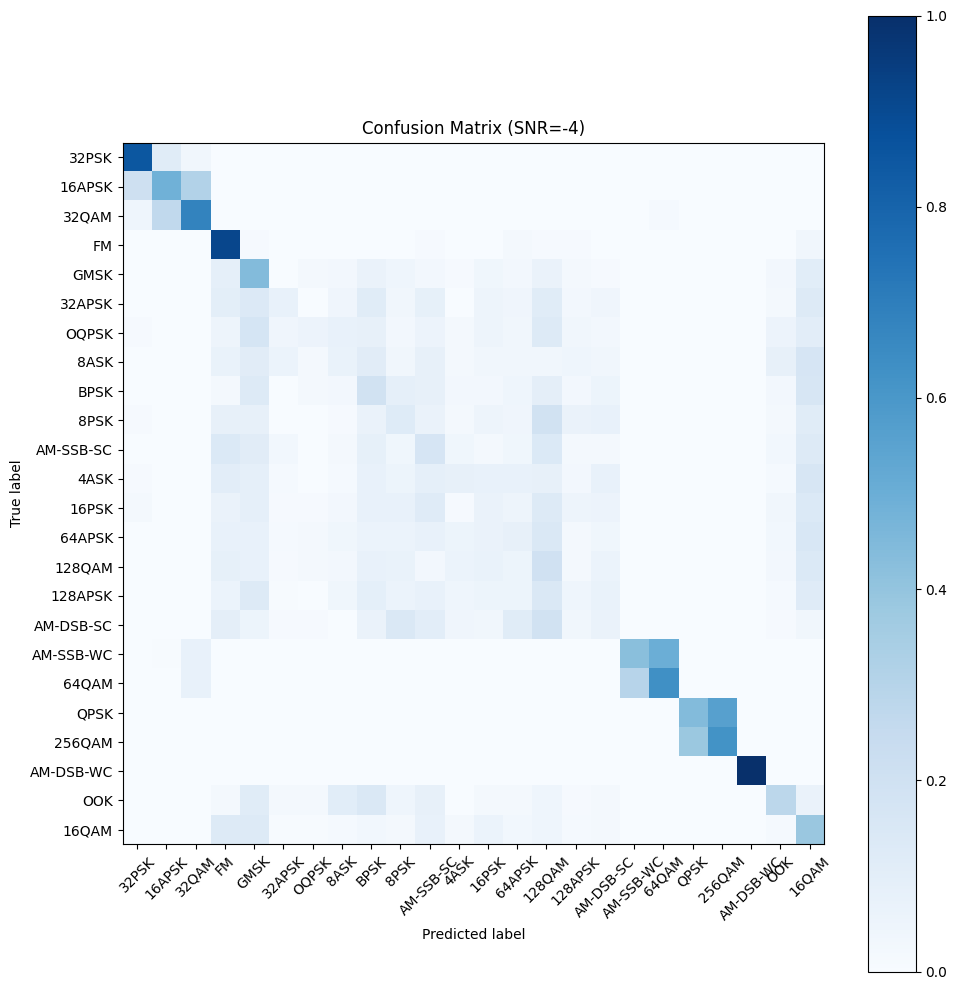

<Figure size 640x480 with 0 Axes>

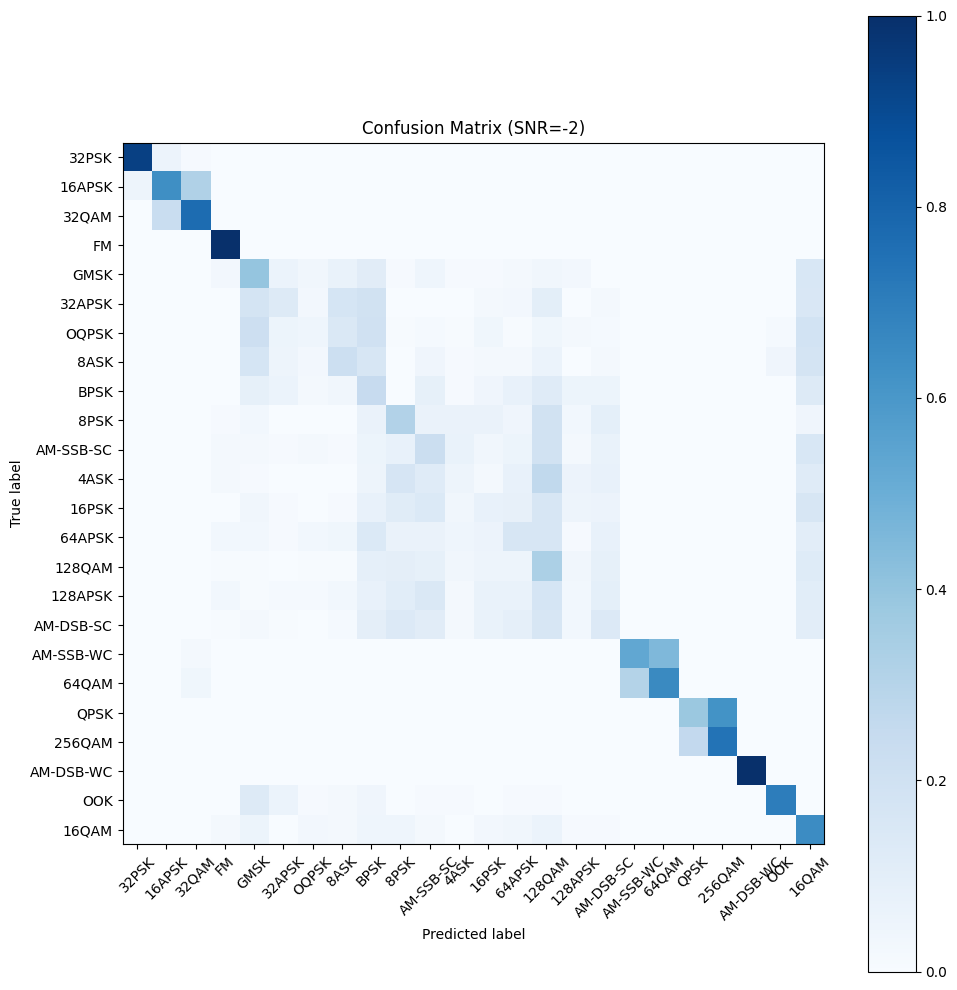

<Figure size 640x480 with 0 Axes>

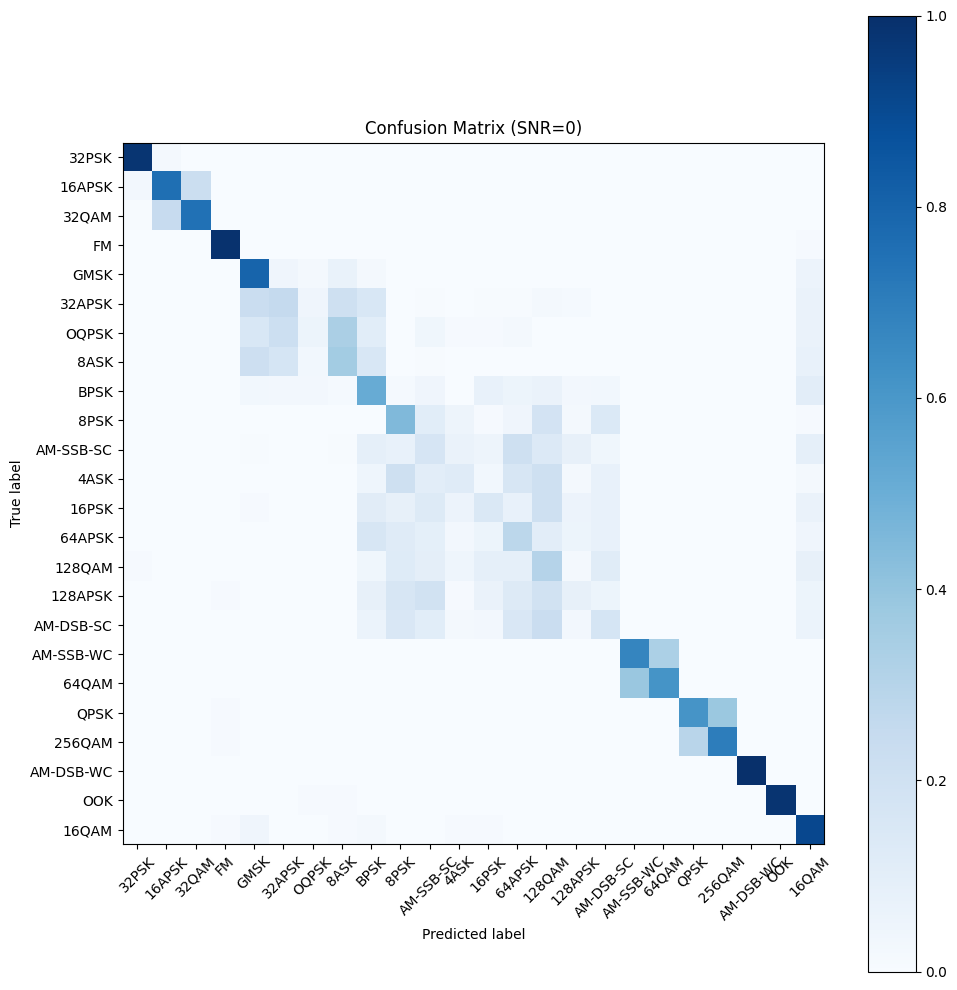

<Figure size 640x480 with 0 Axes>

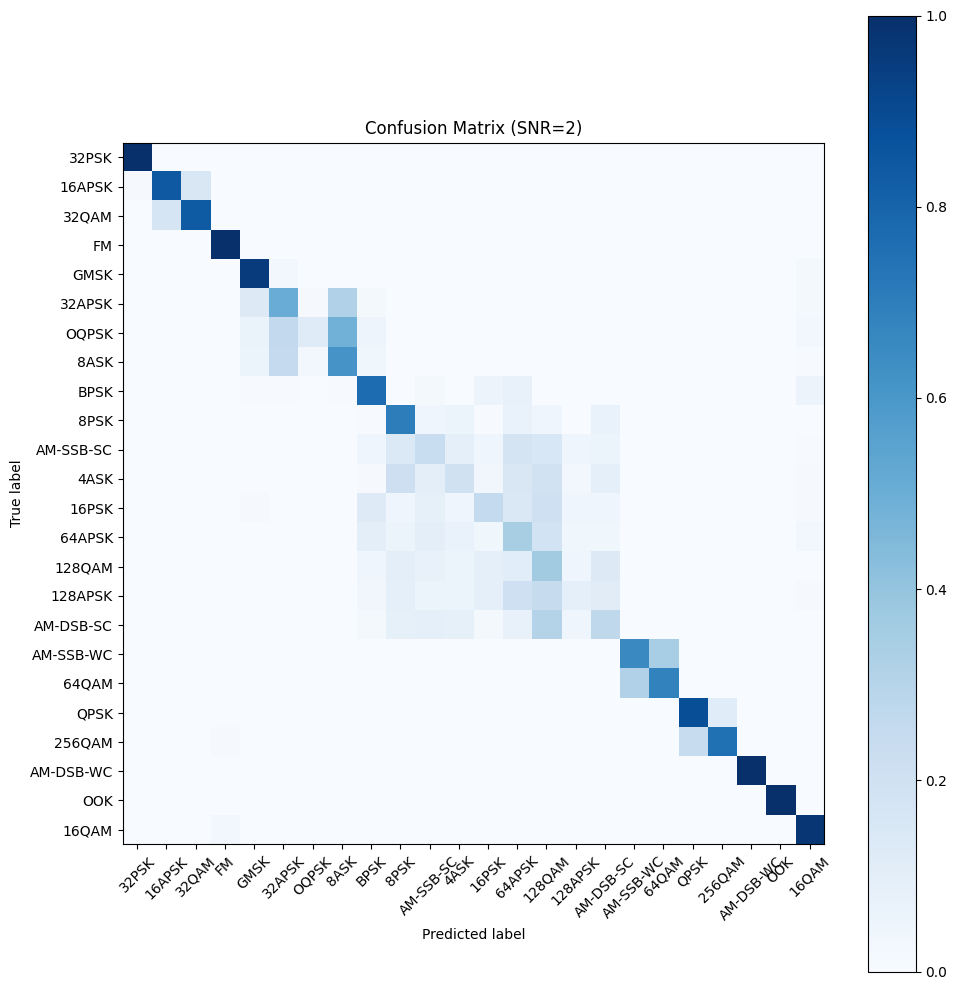

<Figure size 640x480 with 0 Axes>

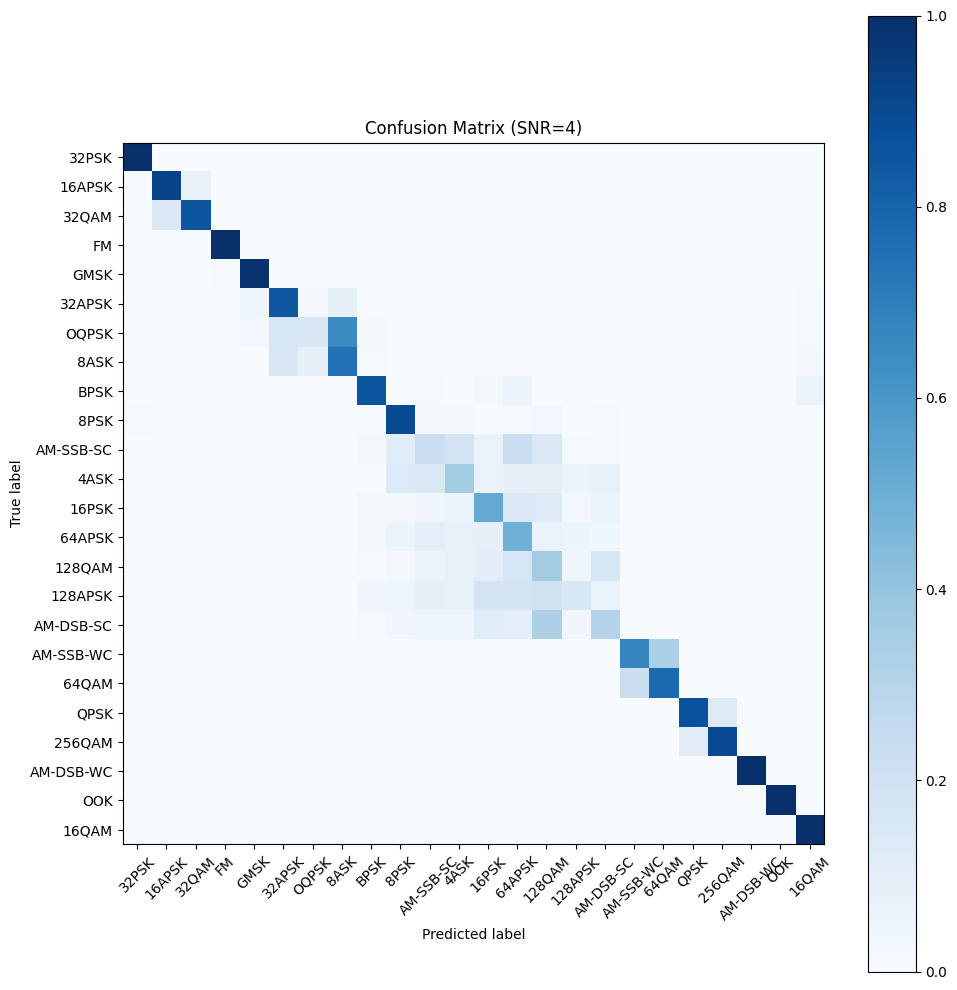

<Figure size 640x480 with 0 Axes>

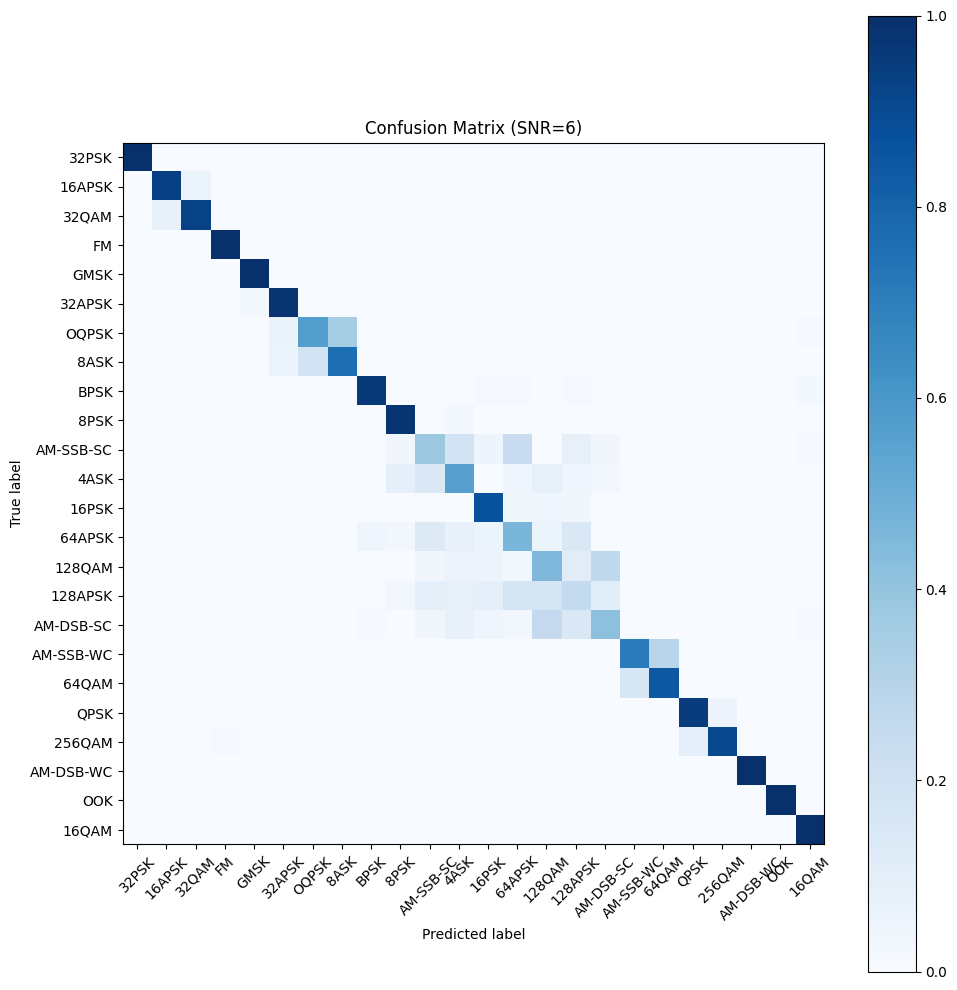

<Figure size 640x480 with 0 Axes>

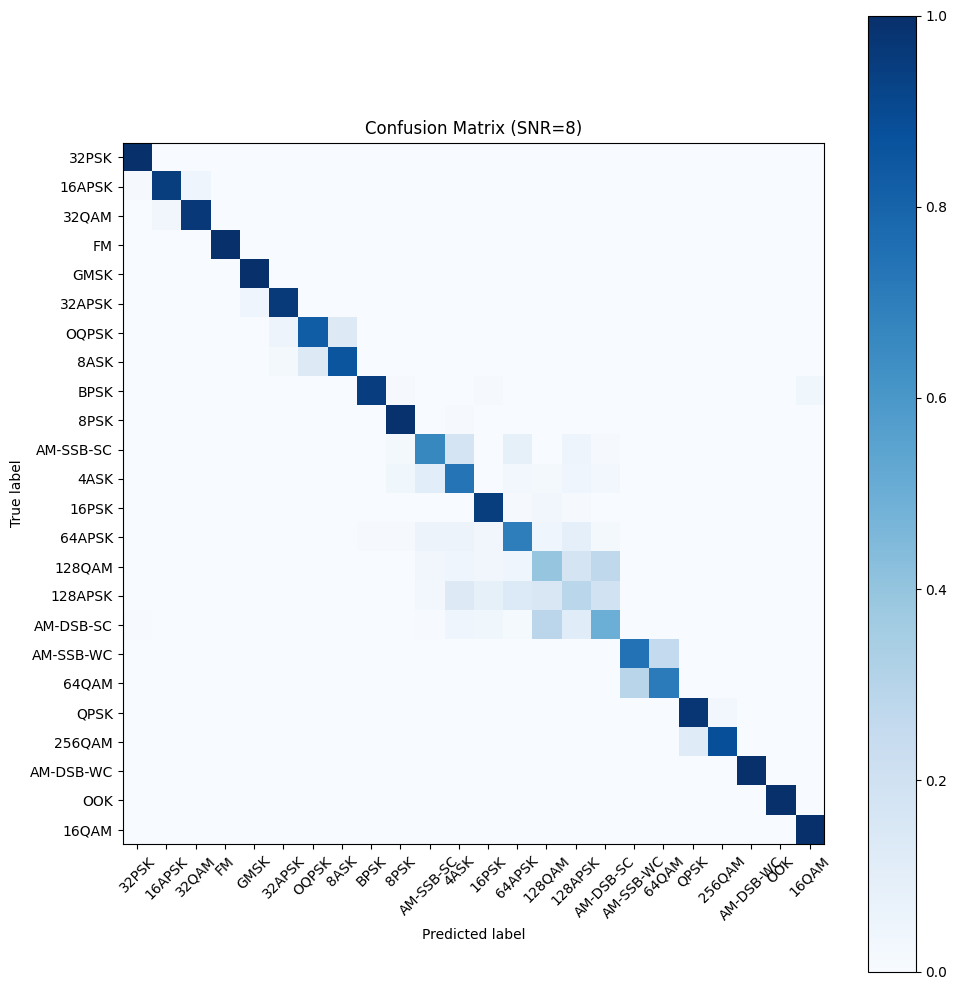

<Figure size 640x480 with 0 Axes>

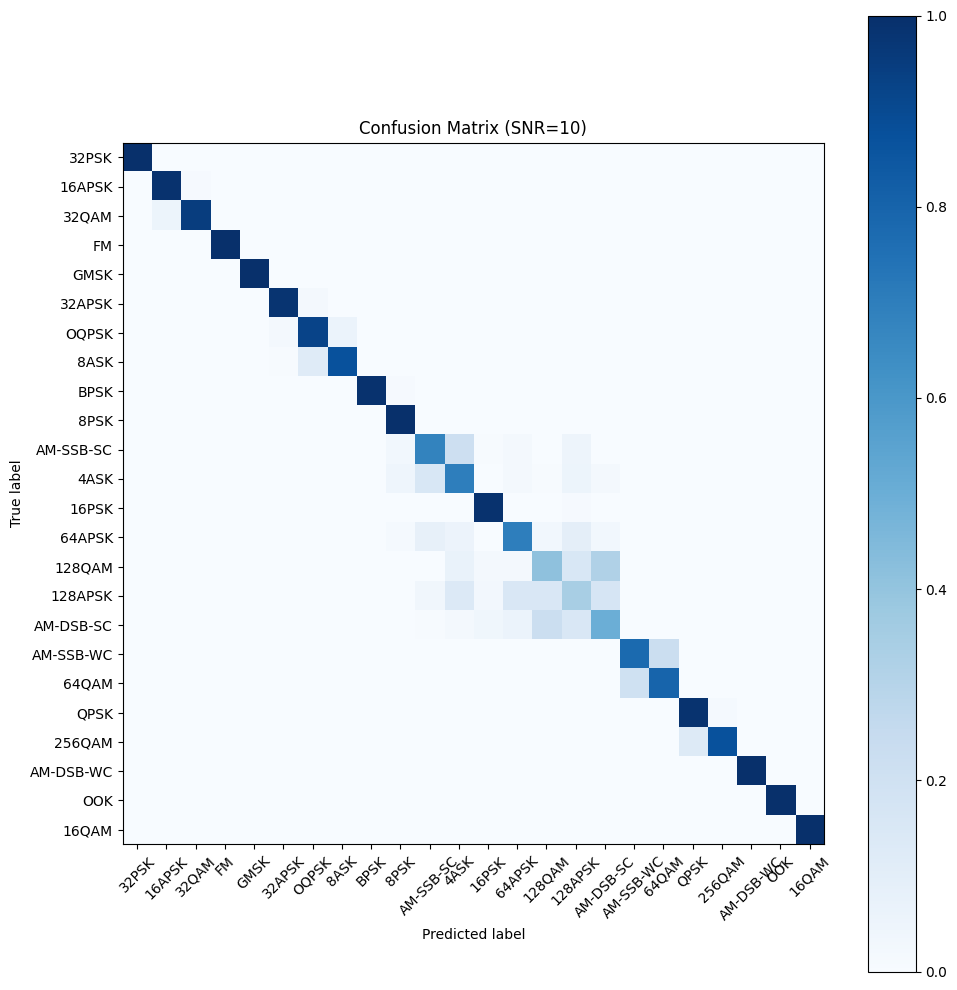

<Figure size 640x480 with 0 Axes>

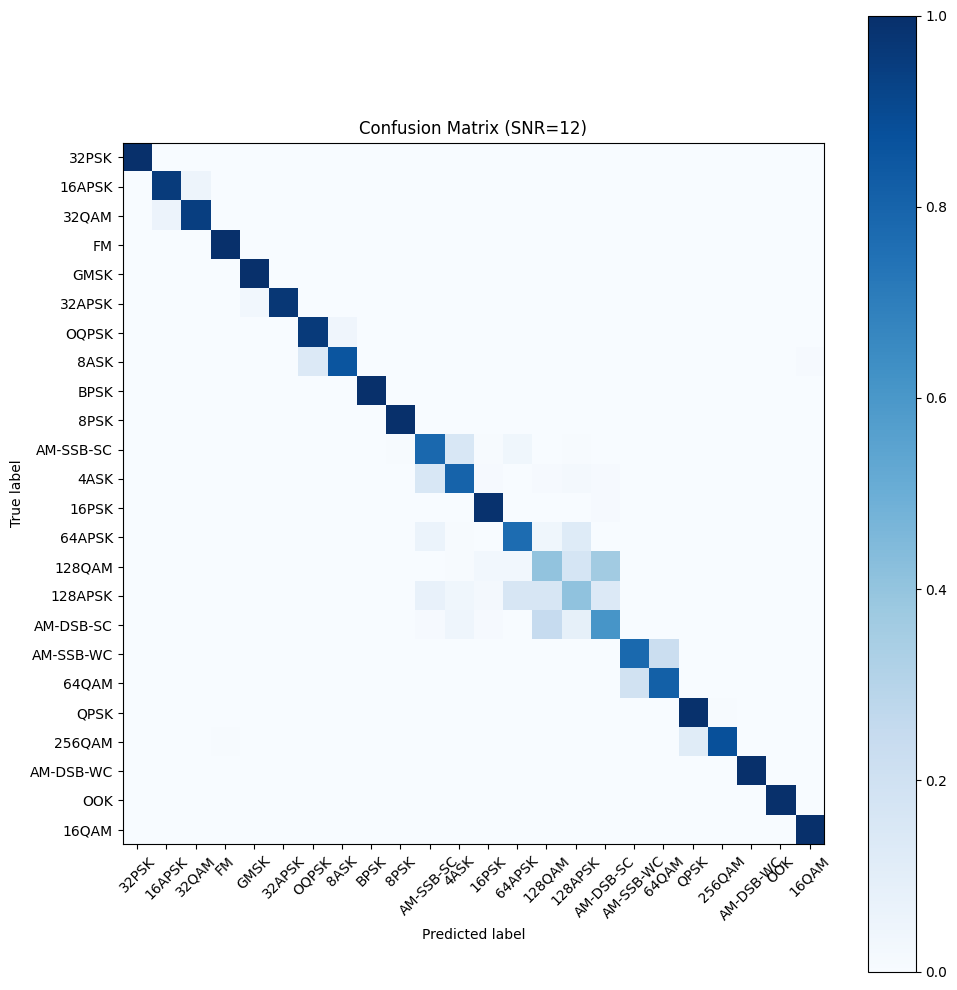

<Figure size 640x480 with 0 Axes>

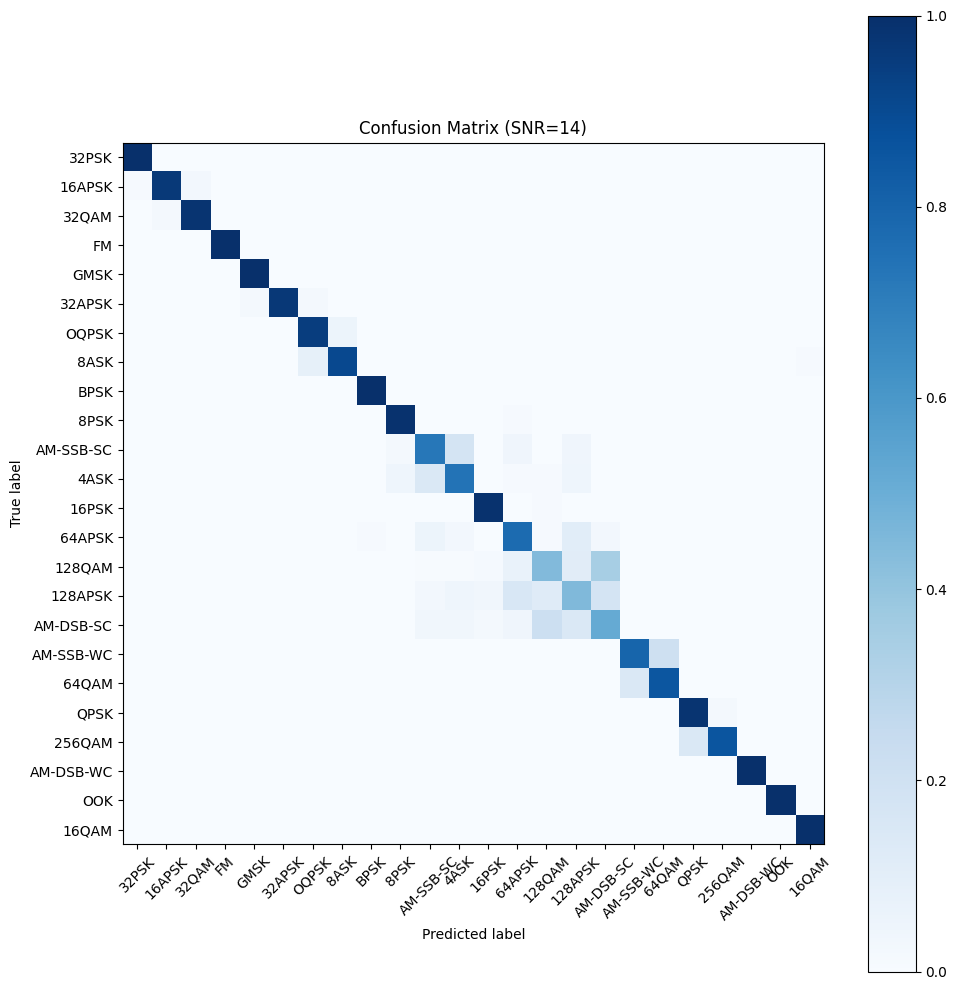

<Figure size 640x480 with 0 Axes>

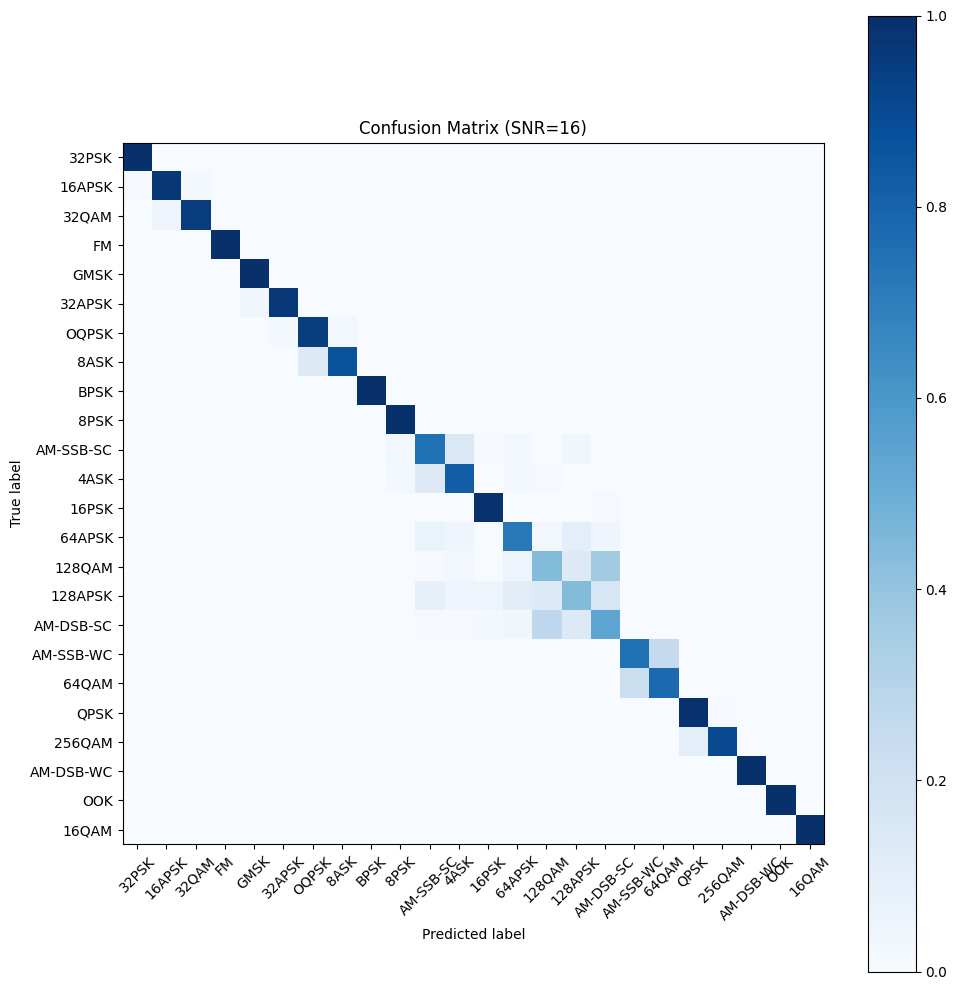

<Figure size 640x480 with 0 Axes>

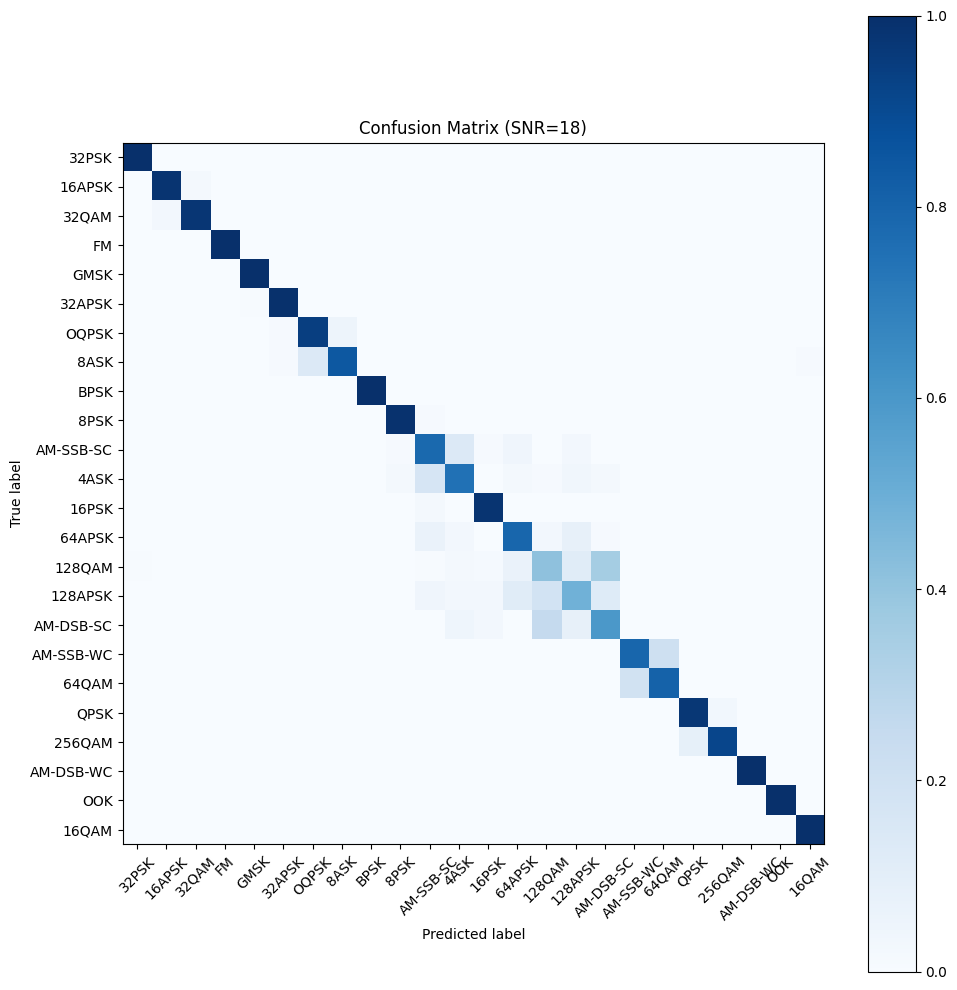

<Figure size 640x480 with 0 Axes>

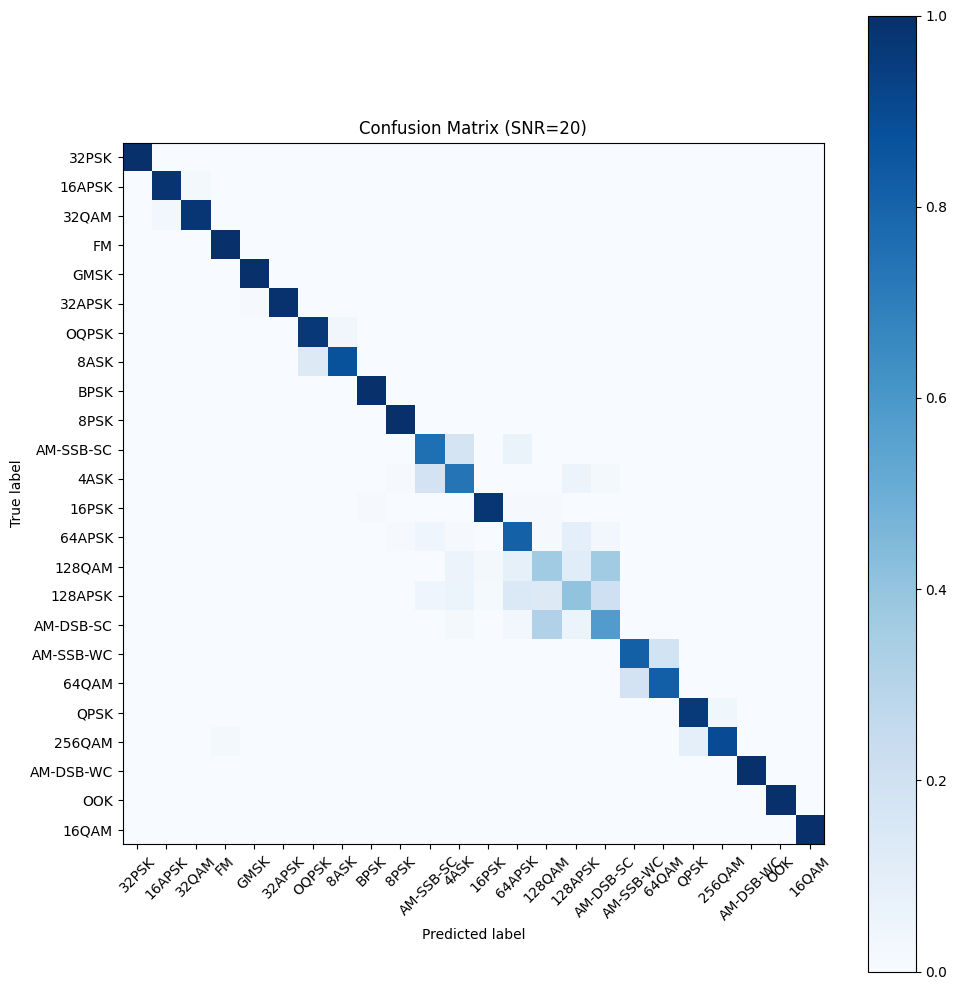

<Figure size 640x480 with 0 Axes>

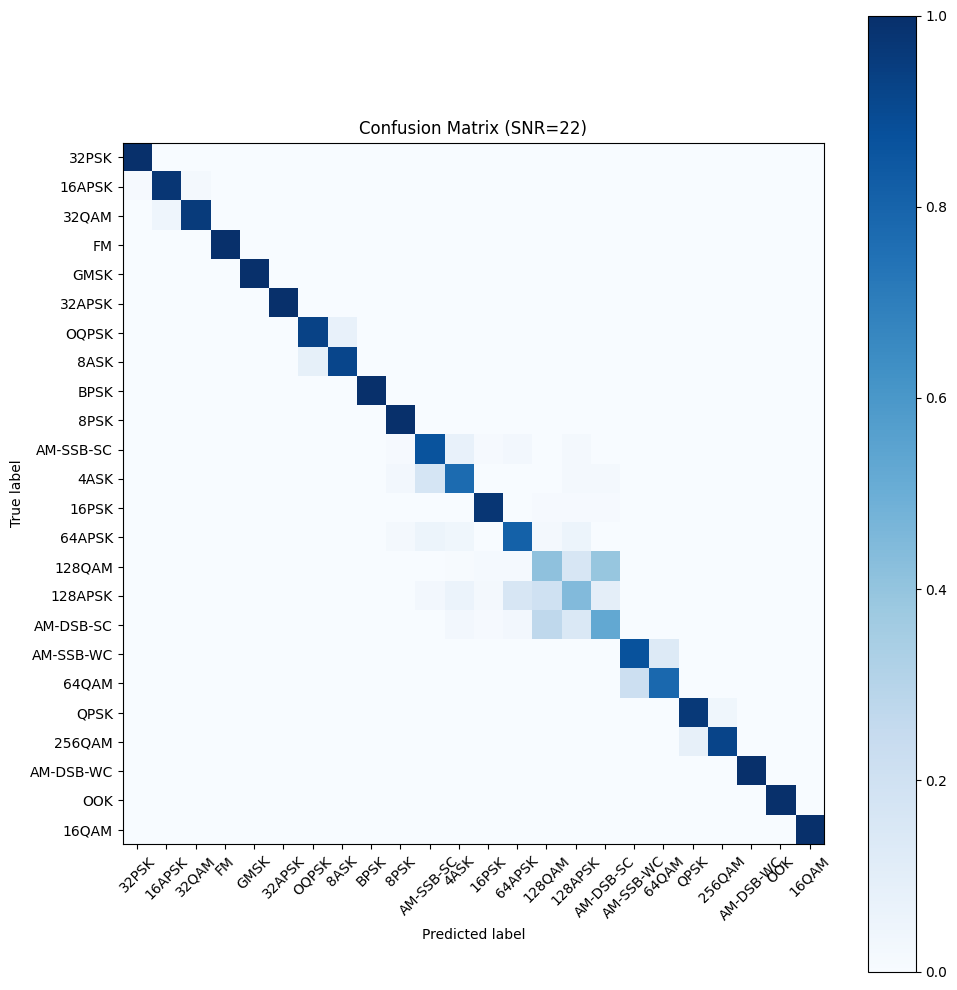

<Figure size 640x480 with 0 Axes>

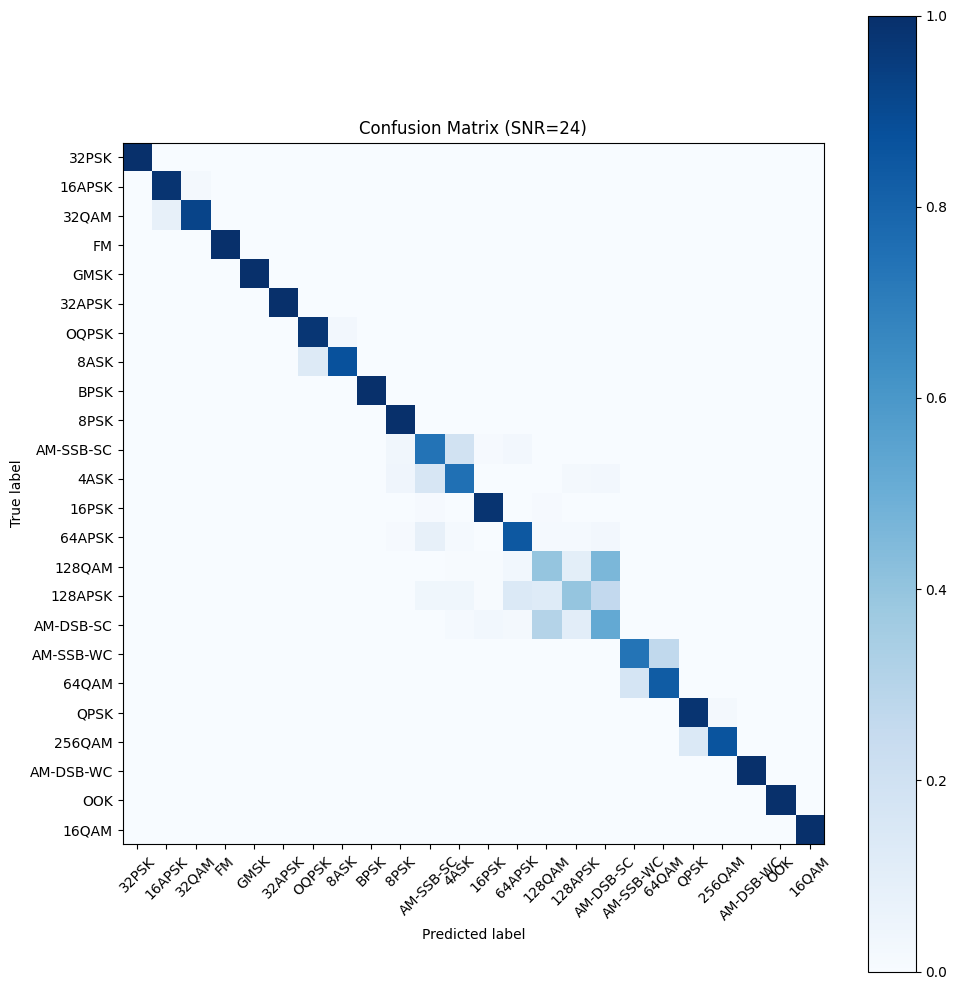

<Figure size 640x480 with 0 Axes>

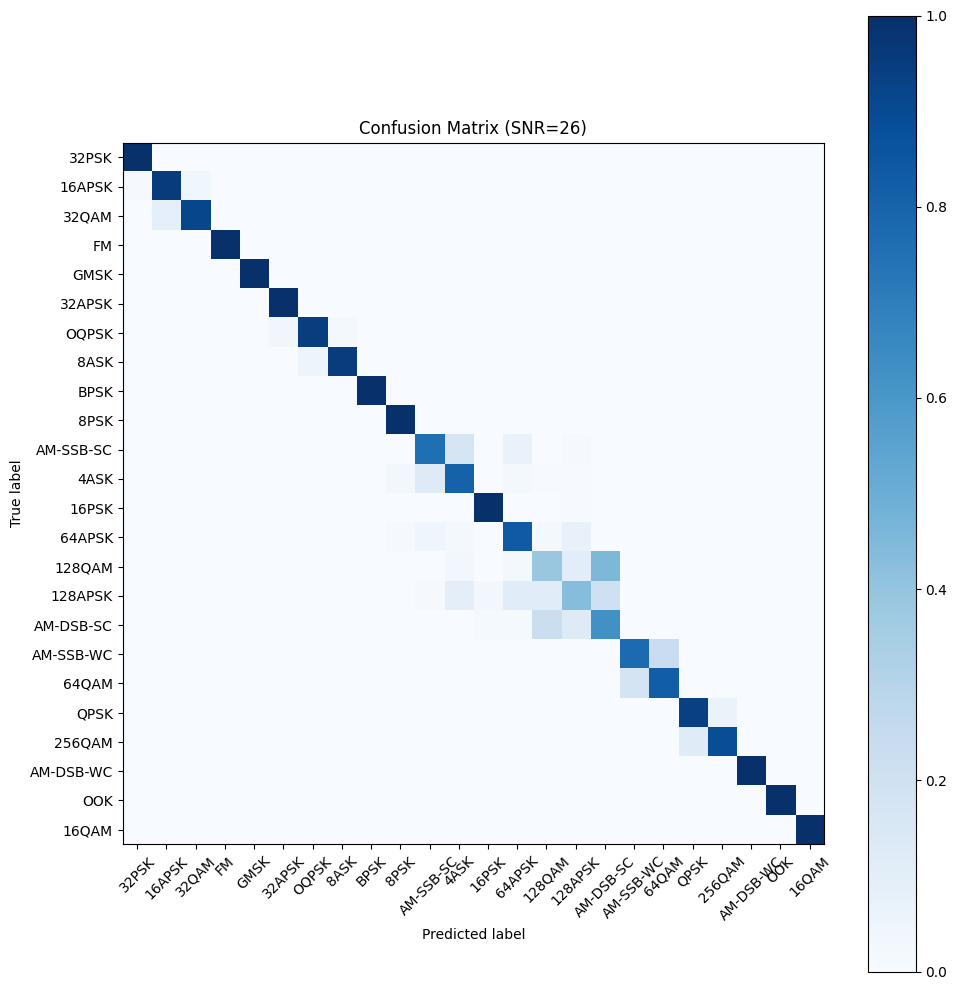

<Figure size 640x480 with 0 Axes>

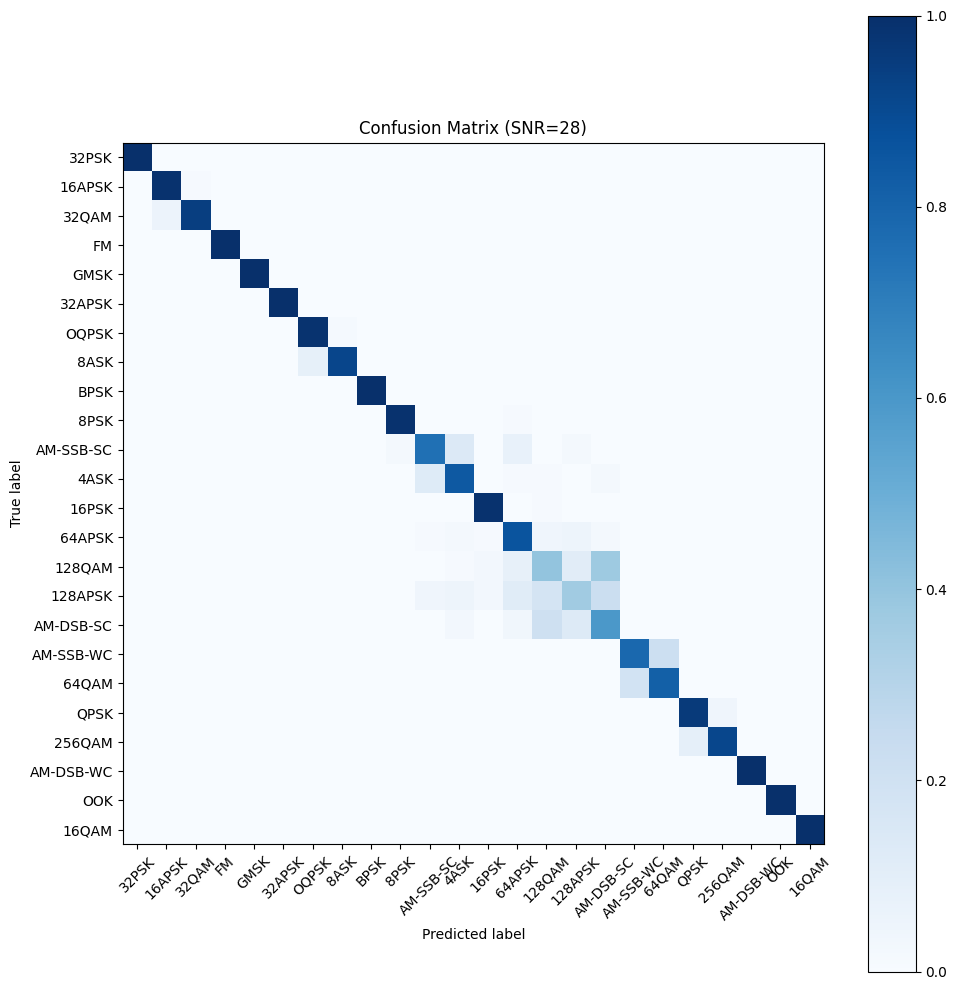

<Figure size 640x480 with 0 Axes>

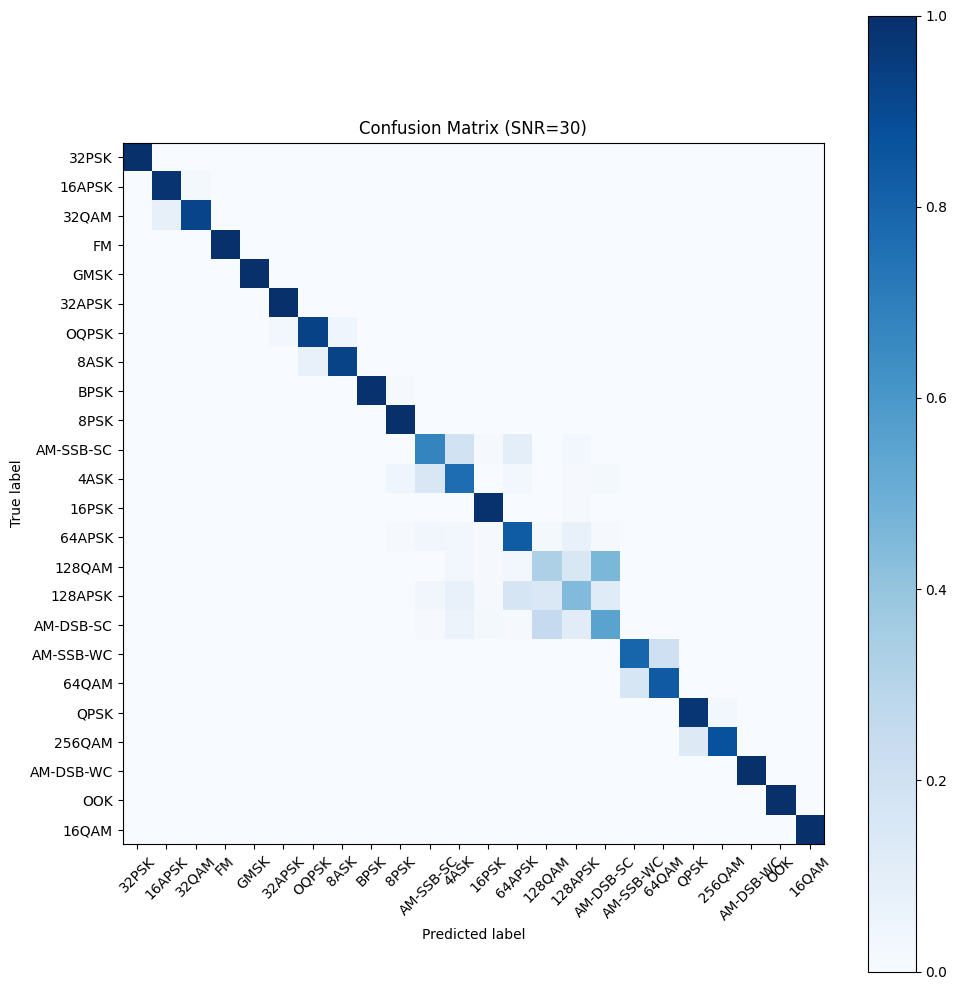

In [9]:
acc={}
Z_test = Z_test.reshape((len(Z_test)))
SNRs = np.unique(Z_test)
for snr in SNRs:
    X_test_snr = X_test[Z_test==snr]
    Y_test_snr = Y_test[Z_test==snr]
    
    pre_Y_test = model.predict(X_test_snr)
    conf = np.zeros([len(classes),len(classes)])
    confnorm = np.zeros([len(classes),len(classes)])
    for i in range(0,X_test_snr.shape[0]):    
        j = list(Y_test_snr[i,:]).index(1)  
        k = int(np.argmax(pre_Y_test[i,:])) 
        conf[j,k] = conf[j,k] + 1
    for i in range(0,len(classes)):
        confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
   
    plt.figure()
    plot_confusion_matrix(confnorm, labels=classes, title="Confusion Matrix (SNR=%d)"%(snr))
    
    cor = np.sum(np.diag(conf))
    ncor = np.sum(conf) - cor
    print ("Overall Accuracy %s: "%snr, cor / (cor+ncor))
    acc[snr] = 1.0*cor/(cor+ncor)

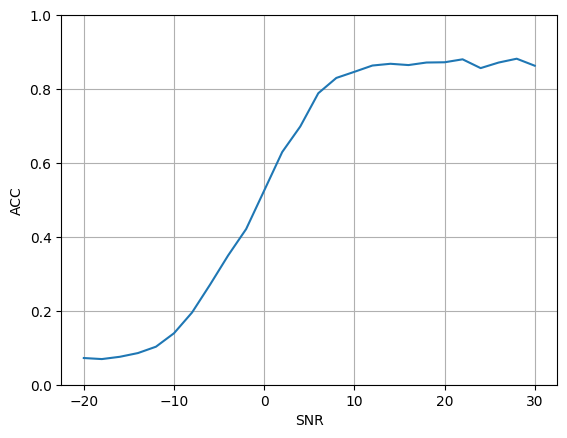

In [10]:
plt.plot(acc.keys(),acc.values())
plt.ylabel('ACC')
plt.xlabel('SNR')
plt.ylim(0, 1)
plt.grid(True)
plt.show()